# Jupyter et calcul distribué

In [ ]:
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

Avec de commencer, quelques mots de vocabulaire :

* [thread](http://fr.wikipedia.org/wiki/Thread_%28informatique%29) : il est possible de paralléliser un traitement au sein d'un même programme ou processus, c'est un *thread*. Les threads ont accès aux mêmes variables.
* [processus](http://fr.wikipedia.org/wiki/Processus_%28informatique%29) : c'est un programme, chaque processus a sa propre mémoire non partagée avec d'autres processus.


<h3 id="cd">Calcul distribué</h3>

Quelques liens :

* [Overview and getting started with ipyrallel](https://ipyparallel.readthedocs.io/en/latest/)
La distribution d'un programme implique l'exécution en parallèle de morceaux de programme, sur la même machine ou sur des machines différentes. Dans le cas de cette séance, ce sera sur la même machine mais le principe reste le même : une machine centrale (serveur) envoie des données et le traitement associé sur d'autres machines (clients). Pour que les clients comprennent qu'ils doivent exécuter un programme, ils doivent continuellement attendre qu'on leur envoie des instructions : un client est lancé puis attend des instructions. Pour lancer des clients localement sur cette machine, on doit aller dans le répertoire :

In [ ]:
import os,sys
if hasattr(sys, 'real_prefix'):
    exe = sys.real_prefix
else:
    exe = sys.base_exec_prefix
f = os.path.join(exe, "Scripts")
f

'c:\\python35_x64\\Scripts'

In [ ]:
[ _ for _ in os.listdir(f) if "cluster" in _ ]

['ipcluster.exe']

Il faut exécuter l'instruction ``ipcluster start -n 2`` depuis une ligne de commande. Celle-ci vient avec le module [ipyparallel](https://ipyparallel.readthedocs.org/en/latest/) ``2`` signifie deux clients puis on vérifie que ceux-ci sont bien en train de s'exécuter. Sous Windows, il faut ouvrir une fenêtre de commande avec la commande [cmd](http://windows.microsoft.com/fr-fr/windows/command-prompt-faq#1TC=windows-8).

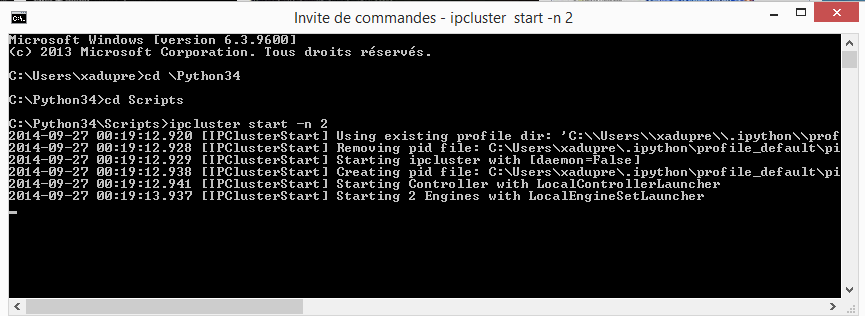

In [ ]:
from pyquickhelper.helpgen import NbImage
NbImage("cmdipc.png")

On vérifie que les deux clients sont accessibles depuis de notebook :

In [ ]:
from ipyparallel import Client
clients = Client()
clients.block = True  # use synchronous computations
print (clients.ids)   # on s'attend à deux clients

Waiting for connection file: ~\.ipython\profile_default\security\ipcontroller-client.json


KeyboardInterrupt: 

Tout va bien. L'ensemble fonctionne comme le dessin ci-dessous :

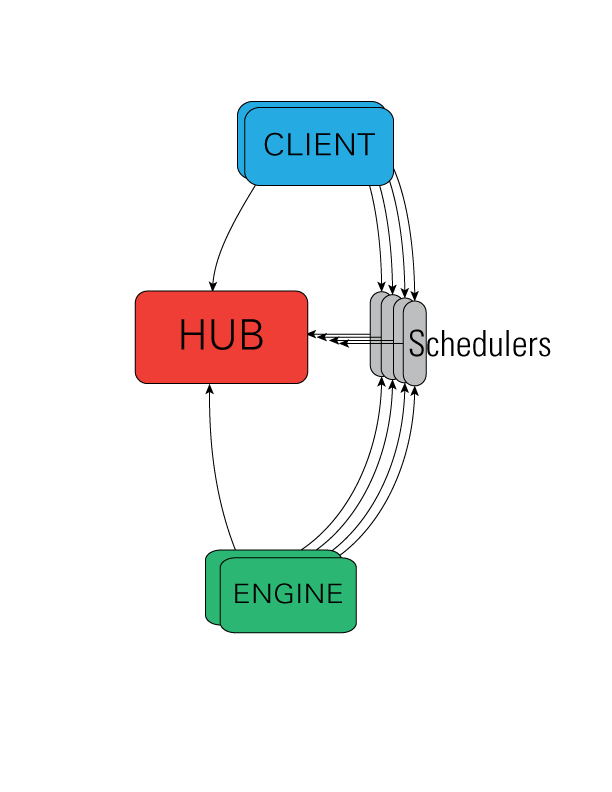

In [ ]:
from IPython.core.display import Image
Image("http://ipython.org/ipython-doc/stable/_images/wideView.png", width=300)

Tout d'abord, on crée une fonction qui sera le traitement qu'on souhaite paralléliser :

In [ ]:
def inverse_matrice(m) :
    return numpy.linalg.inv ( m )

Ensuite, on créer 100 matrices à inverser :

In [ ]:
import numpy
ms = [ numpy.random.random ( (5,5) )  for i in range(0,1000) ]

Puis on crée une [view](https://ipyparallel.readthedocs.io/en/latest/api/ipyparallel.html?ipyparallel.LoadBalancedView) *load balanced* :

In [ ]:
view = clients.load_balanced_view()

NameError: name 'clients' is not defined

Qu'on utilise pour dispatcher les résultats sur plusieurs processus :

In [ ]:
results = view.map(inverse_matrice, ms)
len(results)

Le module ``numpy`` a été importé dans ce notebook mais il ne l'a pas été sur les processus distribués :

In [ ]:
with clients[:].sync_imports():
    import numpy

On recommence à exécuter le code suivant :

In [ ]:
results = view.map(inverse_matrice, ms)
len(results)

On compare avec un traitement non distribué :

In [ ]:
%timeit list(map(inverse_matrice, ms))

In [ ]:
%timeit view.map(inverse_matrice, ms)

Le processus distribué est plus long : cela prend du temps de communiquer les matrices depuis ce notebook vers les *engines*. Ce temps est manifestement plus long. C'est pourquoi on distribue généralement des processus dont le calcul est significativement plus lent que le temps de communication. Selon ce schéma, on préfère envoyer des noms de fichiers au processus pour ce recevoir des résultats courts. Pour distribuer, il faut faire attention au ratio communication/calcul. La fonction suivante ne reçoit rien, fait beaucoup de calcul et retourne une matrice 10x10.

In [ ]:
def average_random_matrix(i):
    mean = None
    for n in range(0,100000):
        m = numpy.random.random ( (10,10) )
        if mean is None : mean = m
        else : mean += m
    return mean / n

In [ ]:
%timeit list(map(average_random_matrix, range(0,10)))

In [ ]:
%timeit view.map(average_random_matrix, range(0,10))

La distribution commence à montrer un gain de temps. Elle ne devient généralement intéressante que si un traitement numérique dure au moins quelques secondes.

### autres options pour distribuer les calculs

IPython n'est pas le seul module à proposer un méchanisme de parallélisation. Un problème récurrent et souvent très agaçant est l'**erreur qui oblige à tout recommencer depuis le depuis**. On parallélise pour gagner du temps et une erreur se produit au bout de trois heures à cause d'une division par zéro par exemple. Il existe des modules qui sauvent les résultats intermédiaires et ne recommencent pas les calculs déjà effectués :

* [joblib](http://pythonhosted.org//joblib/index.html) : très simple d'utilisation, le module parallélise des tâches sur plusieurs processus sans que vous ayez à vous soucier des échanges entre processus.
* [luigi](https://github.com/spotify/luigi) : c'est un système pour les long [workflow](http://en.wikipedia.org/wiki/Workflow) (plusieurs heures ou jours), il permet de voir visuellement l'avancement.

Il existe d'autres options comme [pyina](http://trac.mystic.cacr.caltech.edu/project/pathos/wiki/pyina). Une des premières solutions capable de faire cela était [RPyC](http://rpyc.readthedocs.org/en/latest/). Lorsqu'on veut distribuer sur plusieurs machines, il faut faire attention à :

* Les machines sont-elles sur un réseau local ou distantes (Azure, Amazon, ...) ?
* Les communications doivent-elles encryptées ?

Quelques pointeurs :

* [An introduction to 0mq](http://nichol.as/zeromq-an-introduction)
* [Using IPython for parallel computing](http://ipython.org/ipython-doc/stable/parallel/index.html)
* [mpi4py](http://pythonhosted.org//mpi4py/)

### un peu plus sur les threads

Le module [threading](https://docs.python.org/3.4/library/threading.html) propose une interface pour créer des threads. C'est utile pour exécuter des fonctions en parallèle. Toutefois, comme le langage Python n'est pas un langage multithreadé (voir [Global Interpreter Lock](http://en.wikipedia.org/wiki/Global_Interpreter_Lock), il ne sera pas plus rapide du point de vue vitesse de calcul. La fonction suivante montre comment à partir de la librairie standard  [threading](https://docs.python.org/3.4/library/threading.html) on peut paralléliser un traitement (voir [ParallelThread](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/_modules/td_2a/parallel_thread.html)).

In [ ]:
import numpy
ms = [ numpy.random.random ( (5,5) )  for i in range(0,100000) ]

def inverse_matrice(m) :
    return numpy.linalg.inv ( m )

from ensae_teaching_cs import ParallelThread
%timeit res = ParallelThread.parallel( inverse_matrice, [ (m,) for m in ms ], 4, delay_sec = 0.1 )

Ce code sera plus lent que d'appeler la fonction directement car il faudra en plus passer du temps à attendre la fin des autres threads ou fils d'exécution.

In [ ]:
%timeit list(map(inverse_matrice, ms))

### Exercice 1 : Distribuer un calcul

In [ ]:
import pyensae
pyensae.download_data("td8_velib.zip")

In [ ]:
import pandas
df = pandas.read_csv("td8_velib.txt", sep="\t")

In [ ]:
df.shape

In [ ]:
df.columns

In [ ]:
df = df.sort_values("collect_date")
df.head()

La colonne ``number`` indique le numéro d'une station de vélo. On peut calculer le pourcentage de places disponibles sur l'ensemble des places de chaque station, on moyenne ce pourcentage pour chaque heure de la journée. Pour chaque station, on a un vecteur qui correspond à un pourcentage pour chaque heure de la journée. On veut constuire la matrice de corrélation de ces vecteurs, si possible en distribuant.